## Functions

In [ ]:
# Converts a number in base10 to base2.

def to_binary(num_10):
  N = num_10
  output = ''

  while N > 1:
    if N % 2 == 1:
      output += '1'
      N = (N-1) // 2
      continue

    N = N // 2
    output += '0'
  output += '1'

  return output[::-1]

# Euclid's algorithm.
def gcd(a, b):
  if a < b:
    a, b = b, a
  # Get the remainder when a is divided by b: a = b*k + r, where 0 <= r < b.
  r = a % b
  # If r = 0 then b | a and we are done.
  if r == 0:
    return b
  # If b does not divide a then the gcd(a, b) will be the largest integer dividing b and r.
  return gcd(b, r)

# (!) DO NOT USE. The Bezout coefficients are wrong.
# Need to figure out why this is wrong.
def wrong_ext_gcd(a, b):
  if a < b:
    a, b = b, a

  # Initialize.
  s_prev, t_prev = 1, 0
  s, t = 0, 1
  q = a // b
  r_prev, r = b, a % b

  while True:
    # We will need to update both s, t and s_next, t_next
    s_tmp, t_tmp = s, t
    # Update step is s_n = s_{n-2} - q_n*s_{n-1} and similarly for t_n.
    s, t = s_prev - q*s, t_prev - q*t
    # Update s, t
    s_prev, t_prev = s_tmp, t_tmp
    print(s_prev, t_prev)
    if r == 0:
      return r_prev, s, t
    # Else update r's and q.
    # r != 0
    q = r_prev // r
    r_prev, r = r, r_prev % r

# Correct implementation. This works for the same reason that the gcd algorithm works:
# because gcd(a, b) = gcd(b, a mod b). Assuming that gcd(b, a mod b) = bx + (a mod b)y,
# substitute a mod b = a - a // b to get that gcd(a, b) = ay + b(x - (a // b)*y).
def ext_gcd(a, b):
  if b == 0:
    return (a, 1, 0)
  gcd, x1, y1 = ext_gcd(b, a % b)
  x = y1
  y = x1 - (a // b) * y1
  return (gcd, x, y)

def legendre_symbol(a, p):
    """Compute the Legendre symbol (a | p)"""
    ls = pow(a, (p - 1) // 2, p)
    return -1 if ls == p - 1 else ls

# Tonelli-Shanks algorithm (ChatGPT)
def tonelli_shanks(a, p):
    """
    Solve for x such that x^2 ≡ a mod p, using the Tonelli–Shanks algorithm.
    Requires that p is an odd prime and a is a quadratic residue mod p.
    Returns one solution (the other is p - x).
    Raises ValueError if no square root exists.
    """
    if legendre_symbol(a, p) != 1:
        raise ValueError(f"{a} is not a square mod {p}")

    # Handle the easy case
    if p % 4 == 3:
        return pow(a, (p + 1) // 4, p)

    # Step 1: Factor p-1 = Q * 2^S with Q odd
    Q = p - 1
    S = 0
    while Q % 2 == 0:
        Q //= 2
        S += 1

    # Step 2: Find a non-residue z
    for z in range(2, p):
        if legendre_symbol(z, p) == -1:
            break
    c = pow(z, Q, p)

    # Step 3: Initialize variables
    R = pow(a, (Q + 1) // 2, p)
    t = pow(a, Q, p)
    M = S

    # Step 4: Loop until t == 1
    while t != 1:
        # Find the least i such that t^(2^i) ≡ 1
        i = 1
        temp = pow(t, 2, p)
        while temp != 1:
            temp = pow(temp, 2, p)
            i += 1
            if i == M:
                raise Exception("No solution found")

        # Update variables
        b = pow(c, 1 << (M - i - 1), p)
        R = (R * b) % p
        t = (t * b * b) % p
        c = (b * b) % p
        M = i

    return R


## Structure of AES

In [ ]:
def bytes2matrix(text):
    """ Converts a 16-byte array into a 4x4 matrix.  """
    return [list(text[i:i+4]) for i in range(0, len(text), 4)]

def matrix2bytes(matrix):
    """ Converts a 4x4 matrix into a 16-byte array.  """
    output = b''
    for row in matrix:
      # The entries of the matrix are integers so they need to be converted to
      # bytes.
      for integer in row:
        output += integer.to_bytes(1, byteorder='big') # 2 bytes is too much.
    return output

matrix = [
    [99, 114, 121, 112],
    [116, 111, 123, 105],
    [110, 109, 97, 116],
    [114, 105, 120, 125],
]

print(matrix2bytes(matrix))

b'crypto{inmatrix}'


## Round Keys

In [ ]:
state = [
    [206, 243, 61, 34],
    [171, 11, 93, 31],
    [16, 200, 91, 108],
    [150, 3, 194, 51],
]

round_key = [
    [173, 129, 68, 82],
    [223, 100, 38, 109],
    [32, 189, 53, 8],
    [253, 48, 187, 78],
]

def add_round_key(s, k):
  n = len(s)
  output = []
  for i in range(n):
    new_row = []
    for j in range(n):
      new_row.append(s[i][j] ^ k[i][j])
    output.append(new_row)
  return output

print(add_round_key(state, round_key))

[[99, 114, 121, 112], [116, 111, 123, 114], [48, 117, 110, 100], [107, 51, 121, 125]]


In [ ]:
matrix2bytes([[99, 114, 121, 112], [116, 111, 123, 114], [48, 117, 110, 100], [107, 51, 121, 125]])

b'crypto{r0undk3y}'

## Confusion through Substitution

"The fast lookup in an S-box is a shortcut for performing a very nonlinear function on the input bytes."

In [ ]:
s_box = (
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
)

inv_s_box = (
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,
)

state = [
    [251, 64, 182, 81],
    [146, 168, 33, 80],
    [199, 159, 195, 24],
    [64, 80, 182, 255],
]


def sub_bytes(s, sbox=s_box): # This is not supposed to return but modify in place!!!
  output = b''
  n = len(s)
  for i in range(n):
    for j in range(n):
      value = int(sbox[state[i][j]])
      output += value.to_bytes(1)
  return output

print(sub_bytes(state, sbox=inv_s_box))


b'crypto{l1n34rly}'


In [ ]:
print(len(s_box), len(inv_s_box))

256 256


## Diffusion through Permutation
Confusion then diffusion. Also see https://en.wikipedia.org/wiki/Avalanche_effect. Ideally, changing one bit should change statistically about half of the other bits.

In [ ]:
import copy

In [ ]:
def shift_rows(s):
    s[0][1], s[1][1], s[2][1], s[3][1] = s[1][1], s[2][1], s[3][1], s[0][1]
    s[0][2], s[1][2], s[2][2], s[3][2] = s[2][2], s[3][2], s[0][2], s[1][2]
    s[0][3], s[1][3], s[2][3], s[3][3] = s[3][3], s[0][3], s[1][3], s[2][3]

# DO NOT USE. There is something wrong with this function that this exercise is not detecting,
# but I don't know what it is.
def inv_shift_rows(s):
    s_copy = copy.deepcopy(s) # Make a copy of s.
    n = len(s)
    for i in range(n):
      for j in range(n):
        s[i][j] = s_copy[(i-j) % n][j] # Shifts the ith row i units to the right.


# learned from http://cs.ucsb.edu/~koc/cs178/projects/JT/aes.c
xtime = lambda a: (((a << 1) ^ 0x1B) & 0xFF) if (a & 0x80) else (a << 1)


def mix_single_column(a):
    # see Sec 4.1.2 in The Design of Rijndael
    t = a[0] ^ a[1] ^ a[2] ^ a[3]
    u = a[0]
    a[0] ^= t ^ xtime(a[0] ^ a[1])
    a[1] ^= t ^ xtime(a[1] ^ a[2])
    a[2] ^= t ^ xtime(a[2] ^ a[3])
    a[3] ^= t ^ xtime(a[3] ^ u)


def mix_columns(s):
    for i in range(4):
        mix_single_column(s[i])


def inv_mix_columns(s):
    # see Sec 4.1.3 in The Design of Rijndael
    for i in range(4):
        u = xtime(xtime(s[i][0] ^ s[i][2]))
        v = xtime(xtime(s[i][1] ^ s[i][3]))
        s[i][0] ^= u
        s[i][1] ^= v
        s[i][2] ^= u
        s[i][3] ^= v

    mix_columns(s)


state = [
    [108, 106, 71, 86],
    [96, 62, 38, 72],
    [42, 184, 92, 209],
    [94, 79, 8, 54],
]

inv_mix_columns(state)
inv_shift_rows(state)
matrix2bytes(state)

b'crypto{d1ffUs3R}'

In [ ]:
# Check that inv_shift_rows was implemented correctly.
import copy

state = [
    [108, 106, 71, 86],
    [96, 62, 38, 72],
    [42, 184, 92, 209],
    [94, 79, 8, 54],
]

tmp = copy.deepcopy(state)
shift_rows(tmp)
inv_shift_rows(tmp)
tmp == state

True

## Bringing It All Together

In [ ]:
def inv_shift_rows(s): # There was something wrong with this function!! Maybe there was an issue with deepcopy?
    s[1][1], s[2][1], s[3][1], s[0][1] = s[0][1], s[1][1], s[2][1], s[3][1]
    s[2][2], s[3][2], s[0][2], s[1][2] = s[0][2], s[1][2], s[2][2], s[3][2]
    s[3][3], s[0][3], s[1][3], s[2][3] = s[0][3], s[1][3], s[2][3], s[3][3]

N_ROUNDS = 10

key        = b'\xc3,\\\xa6\xb5\x80^\x0c\xdb\x8d\xa5z*\xb6\xfe\\'
ciphertext = b'\xd1O\x14j\xa4+O\xb6\xa1\xc4\x08B)\x8f\x12\xdd'

def expand_key(master_key):
    """
    Expands and returns a list of key matrices for the given master_key.
    """

    # Round constants https://en.wikipedia.org/wiki/AES_key_schedule#Round_constants
    r_con = (
        0x00, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40,
        0x80, 0x1B, 0x36, 0x6C, 0xD8, 0xAB, 0x4D, 0x9A,
        0x2F, 0x5E, 0xBC, 0x63, 0xC6, 0x97, 0x35, 0x6A,
        0xD4, 0xB3, 0x7D, 0xFA, 0xEF, 0xC5, 0x91, 0x39,
    )

    # Initialize round keys with raw key material.
    key_columns = bytes2matrix(master_key)
    iteration_size = len(master_key) // 4

    # Each iteration has exactly as many columns as the key material.
    i = 1
    while len(key_columns) < (N_ROUNDS + 1) * 4:
        # Copy previous word.
        word = list(key_columns[-1])

        # Perform schedule_core once every "row".
        if len(key_columns) % iteration_size == 0:
            # Circular shift.
            word.append(word.pop(0))
            # Map to S-BOX.
            word = [s_box[b] for b in word]
            # XOR with first byte of R-CON, since the others bytes of R-CON are 0.
            word[0] ^= r_con[i]
            i += 1
        elif len(master_key) == 32 and len(key_columns) % iteration_size == 4:
            # Run word through S-box in the fourth iteration when using a
            # 256-bit key.
            word = [s_box[b] for b in word]

        # XOR with equivalent word from previous iteration.
        word = bytes(i^j for i, j in zip(word, key_columns[-iteration_size]))
        key_columns.append(word)

    # Group key words in 4x4 byte matrices.
    return [key_columns[4*i : 4*(i+1)] for i in range(len(key_columns) // 4)]

# inv_sub_bytes should modify in place.
def inv_sub_bytes(s):
  n = len(s)
  for i in range(n):
    for j in range(n):
      s[i][j] = inv_s_box[s[i][j]]

def decrypt(key, ciphertext):
    round_keys = expand_key(key) # Remember to start from the last round key and work backwards through them when decrypting
    # Convert ciphertext to state matrix
    state = bytes2matrix(ciphertext)
    # Initial add round key step
    add_round_key(state, round_keys[-1])

    for i in range(N_ROUNDS - 1, 0, -1):
      inv_shift_rows(state)
      inv_sub_bytes(state)
      add_round_key(state, round_keys[i]) # 9 8 7 ... 3 2 1
      inv_mix_columns(state)

    # Run final round (skips the InvMixColumns step)
    inv_shift_rows(state)
    inv_sub_bytes(state)
    add_round_key(state, round_keys[0])

    # Convert state matrix to plaintext
    plaintext = matrix2bytes(state)
    return plaintext

print(decrypt(key, ciphertext))

b'crypto{MYAES128}'


## Modes of Operation Starter

In [ ]:
!pip install pycrypto

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.2/446.2 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycrypto: filename=pycrypto-2.6.1-cp311-cp311-linux_x86_64.whl size=498643 sha256=38e743d1fb111f514308ea129d968adbd9c7d701d4539d5124bb1d1d87423d45
  Stored in directory: /root/.cache/pip/wheels/88/0a/1a/35933feb1f6b635d5b661781fb1361a728fcde50f1cd164b7c
Successfully built pycrypto


In [ ]:
from Crypto.Cipher import AES


# KEY = ?
# FLAG = ?


!@chal.route('/block_cipher_starter/decrypt/<ciphertext>/')
def decrypt(ciphertext):
    ciphertext = bytes.fromhex(ciphertext)

    cipher = AES.new(KEY, AES.MODE_ECB)
    try:
        decrypted = cipher.decrypt(ciphertext)
    except ValueError as e:
        return {"error": str(e)}

    return {"plaintext": decrypted.hex()}


!@chal.route('/block_cipher_starter/encrypt_flag/')
def encrypt_flag():
    cipher = AES.new(KEY, AES.MODE_ECB)
    encrypted = cipher.encrypt(FLAG.encode())

    return {"ciphertext": encrypted.hex()}

/bin/bash: -c: line 1: syntax error near unexpected token `'/block_cipher_starter/decrypt/<ciphertext>/''
/bin/bash: -c: line 1: `@chal.route('/block_cipher_starter/decrypt/<ciphertext>/')'
/bin/bash: -c: line 1: syntax error near unexpected token `'/block_cipher_starter/encrypt_flag/''
/bin/bash: -c: line 1: `@chal.route('/block_cipher_starter/encrypt_flag/')'


## Passwords as Keys

In [ ]:
# !pip uninstall pycrpto
!pip install pycryptodome

In [ ]:
!wget https://gist.githubusercontent.com/wchargin/8927565/raw/d9783627c731268fb2935a731a618aa8e95cf465/words

--2025-07-29 15:22:52--  https://gist.githubusercontent.com/wchargin/8927565/raw/d9783627c731268fb2935a731a618aa8e95cf465/words
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938847 (917K) [text/plain]
Saving to: ‘words’

words               100%[===================>] 916.84K  --.-KB/s    in 0.04s   

2025-07-29 15:22:53 (21.1 MB/s) - ‘words’ saved [938847/938847]



In [ ]:
from Crypto.Cipher import AES
import hashlib
import random


# /usr/share/dict/words from
# https://gist.githubusercontent.com/wchargin/8927565/raw/d9783627c731268fb2935a731a618aa8e95cf465/words
with open("/content/words") as f:
    words = [w.strip() for w in f.readlines()]
keyword = random.choice(words)
KEY = hashlib.md5(keyword.encode()).digest()
# FLAG = ?


!@chal.route('/passwords_as_keys/decrypt/<ciphertext>/<password_hash>/')
def decrypt(ciphertext, password_hash):
    ciphertext = bytes.fromhex(ciphertext)
    key = bytes.fromhex(password_hash)

    cipher = AES.new(key, AES.MODE_ECB)
    try:
        decrypted = cipher.decrypt(ciphertext)
    except ValueError as e:
        return {"error": str(e)}

    return {"plaintext": decrypted.hex()}


!@chal.route('/passwords_as_keys/encrypt_flag/')
def encrypt_flag():
    cipher = AES.new(KEY, AES.MODE_ECB)
    encrypted = cipher.encrypt(FLAG.encode())

    return {"ciphertext": encrypted.hex()}

/bin/bash: -c: line 1: syntax error near unexpected token `'/passwords_as_keys/decrypt/<ciphertext>/<password_hash>/''
/bin/bash: -c: line 1: `@chal.route('/passwords_as_keys/decrypt/<ciphertext>/<password_hash>/')'
/bin/bash: -c: line 1: syntax error near unexpected token `'/passwords_as_keys/encrypt_flag/''
/bin/bash: -c: line 1: `@chal.route('/passwords_as_keys/encrypt_flag/')'


In [ ]:
# Can simply brute force check until we find a match with crytpo{}.
# Start by importing regular expression.
import re

In [ ]:
ciphertext = 'c92b7734070205bdf6c0087a751466ec13ae15e6f1bcdd3f3a535ec0f4bbae66'

In [ ]:
# Now let's try this out on the encrypted flag.
def key_search(ciphertext):
  for word in words:
    keyword = word
    # Note that keyword is encoded into bytes in the argument.
    password_hash = hashlib.md5(keyword.encode()).digest()
    # The decrypt function takes in hex strings. It returns a dictionary: {"plaintext" : hex}
    plaintext = decrypt(ciphertext, password_hash.hex())['plaintext']
    # Convert hex -> bytes to get the flag, then -> string so it can be passed into re.
    plaintext = bytes.fromhex(plaintext)
    plaintext = str(plaintext)
    # match sort of works like a boolean.
    match = re.search('crypto', plaintext)

    if match:
      print(f'The flag is {plaintext} and the keyword used to decrypt it was {keyword}.')
      return
  print('No match was found.')

In [ ]:
ciphertext = 'c92b7734070205bdf6c0087a751466ec13ae15e6f1bcdd3f3a535ec0f4bbae66'
key_search(ciphertext)

The flag is b'crypto{k3y5__r__n07__p455w0rdz?}' and the keyword used to decrypt it was bluebell.


Scratchwork

In [ ]:
# Example of md5 hash:
plaintext = 'crypto{matt_is_cool}' + 12*'0'
print(f'Plaintext must be a multiple of 16: len(plaintext) = {len(plaintext)}')
keyword = 'zygote'
KEY = hashlib.md5(keyword.encode()).digest()
# Encode:
cipher = AES.new(KEY, AES.MODE_ECB)
encrypted = cipher.encrypt(plaintext.encode())
ciphertext = encrypted
ciphertext

Plaintext must be a multiple of 16: len(plaintext) = 32


b'\xae\x16j\x86\xfa%\x96_\xea\xc7b\xfa\xcd\x15F\x9b\xe8\x9c\x11\x89#\xa2\xdd\xd7\xcf\xe8\xd4/\xe0\xee\xaf\xd3'

In [ ]:
plaintext_bytes = cipher.decrypt(ciphertext)
plaintext = str(plaintext_bytes)
print(plaintext)

# If we didn't know the key, then we could search through words to find it.

b'crypto{matt_is_cool}000000000000' <class 'str'>


In [ ]:
print(f'The length of the keyword space is effectively reduced to {len(words)}, the length of the words file.')

for word in words:
  keyword = word
  KEY = hashlib.md5(keyword.encode()).digest()
  cipher = AES.new(KEY, AES.MODE_ECB)
  plaintext_bytes = cipher.decrypt(ciphertext)
  # Not sure if this string conversion is strictly necessary.
  plaintext = str(plaintext_bytes)
  match = re.search('crypto', plaintext)

  if match:
    print(f'The keyword is {keyword} and the plaintext is {plaintext}.')
    break
# This is appears to be working correctly.

The length of the keyword space is effectively reduced to 99171, the length of the words file.
The keyword is zygote and the plaintext is b'crypto{matt_is_cool}000000000000'.


In [ ]:
# re.search is kind of like a boolean?
if re.search(r'matt', 'matt_is_cool'):
  print(0)
else:
  print(1)

0


## ECB Oracle

In [ ]:
!pip install pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.5 MB/s eta 0:00:00


In [ ]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad

# KEY = ?
# FLAG = ?

!@chal.route('/ecb_oracle/encrypt/<plaintext>/')
def encrypt(plaintext):
    plaintext = bytes.fromhex(plaintext)

    padded = pad(plaintext + FLAG.encode(), 16)
    cipher = AES.new(KEY, AES.MODE_ECB)
    try:
        encrypted = cipher.encrypt(padded)
    except ValueError as e:
        return {"error": str(e)}

    return {"ciphertext": encrypted.hex()}

/bin/bash: -c: line 1: syntax error near unexpected token `'/ecb_oracle/encrypt/<plaintext>/''
/bin/bash: -c: line 1: `@chal.route('/ecb_oracle/encrypt/<plaintext>/')'


Example where you know the first letter is 'c' and you are trying to guess the second one.

In [ ]:
flag = 'crypto{matt}'

In [ ]:
pad(('A'*14 + 'cq' + 'A'*14 + flag).encode(), 16)

b'AAAAAAAAAAAAAAcqAAAAAAAAAAAAAAcrypto{matt}\x06\x06\x06\x06\x06\x06'

In [ ]:
symbols = 'abcdefghijklmnopqrstuvwxyz0123456789!@#$%^&*_()[]{}\|<>?":+-='

In [ ]:
'a'*15

'aaaaaaaaaaaaaaa'

## ECB CBC WTF

The plaintext is encrypted in CBC mode, but then decrypted in ECB mode. That means it doesn't XOR with the IV at the final step. The data goes through the following transformation when encrypt/decrypting assuming one block:

Encrypt: plaintext -> IV xor plaintext -> AES(IV xor plaintext) -> ciphertext

Decrypt: ciphertext -> AES_inv().

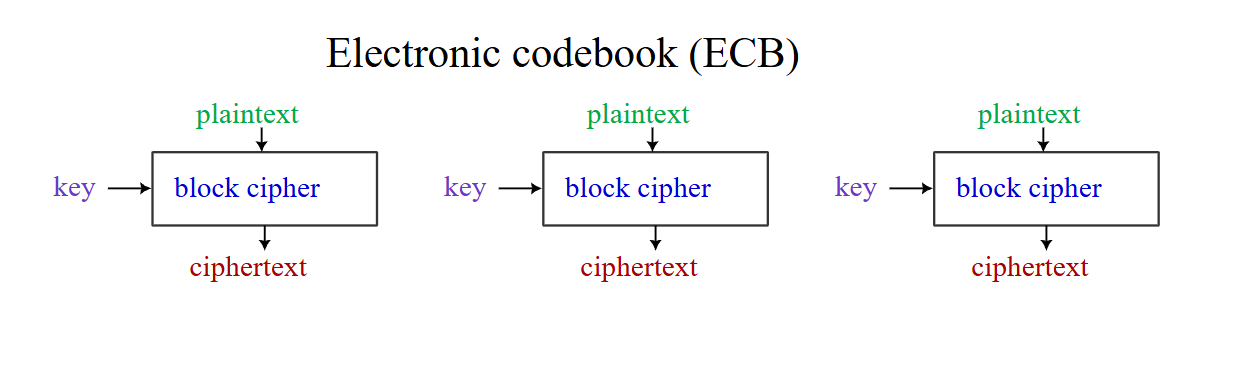

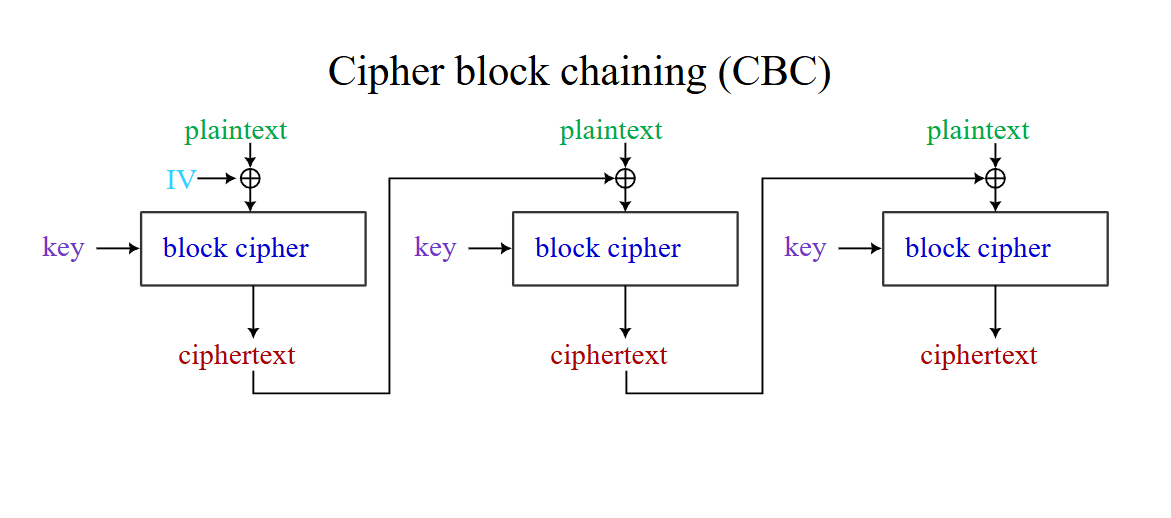

In [ ]:
!pip install pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.9 MB/s eta 0:00:00


In [ ]:
from Crypto.Cipher import AES


# KEY = ?
# FLAG = ?


!@chal.route('/ecbcbcwtf/decrypt/<ciphertext>/')
def decrypt(ciphertext):
    ciphertext = bytes.fromhex(ciphertext)

    cipher = AES.new(KEY, AES.MODE_ECB)
    try:
        decrypted = cipher.decrypt(ciphertext)
    except ValueError as e:
        return {"error": str(e)}

    return {"plaintext": decrypted.hex()}


!@chal.route('/ecbcbcwtf/encrypt_flag/')
def encrypt_flag():
    iv = os.urandom(16)

    cipher = AES.new(KEY, AES.MODE_CBC, iv)
    encrypted = cipher.encrypt(FLAG.encode())
    ciphertext = iv.hex() + encrypted.hex() # note that the iv is appended onto the ciphertext

    return {"ciphertext": ciphertext}


/bin/bash: -c: line 1: syntax error near unexpected token `'/ecbcbcwtf/decrypt/<ciphertext>/''
/bin/bash: -c: line 1: `@chal.route('/ecbcbcwtf/decrypt/<ciphertext>/')'
/bin/bash: -c: line 1: syntax error near unexpected token `'/ecbcbcwtf/encrypt_flag/''
/bin/bash: -c: line 1: `@chal.route('/ecbcbcwtf/encrypt_flag/')'


In [ ]:
# The iv is random, so this is a different output every time.
ciphertext = 'c119a432482b30a6ee5417790d35f555e0f85cb1bf79d613a75f37bb397035b228479fcfa007e4c22720380e925aed1d'
iv = ciphertext[:32] # the first 16 bytes is the iv.
print(iv)
cipher_flag = ciphertext[32:]
iv + cipher_flag == ciphertext

c119a432482b30a6ee5417790d35f555


True

In [ ]:
print(cipher_flag)

len(cipher_flag) # length 64 means that this is 32 bytes, ie two blocks.

e0f85cb1bf79d613a75f37bb397035b228479fcfa007e4c22720380e925aed1d


64

In [ ]:
first_block = cipher_flag[:32]
second_block = cipher_flag[32:]
print(first_block + second_block == cipher_flag, first_block, second_block)

True e0f85cb1bf79d613a75f37bb397035b2 28479fcfa007e4c22720380e925aed1d


In [ ]:
# After using the decrypt function on first_block, we get a26bdd423c444b958d36484c78569e60. Xoring with the iv gives
bytes(x ^ y for x, y in zip(bytes.fromhex('a26bdd423c444b958d36484c78569e60'), bytes.fromhex(iv)))

b'crypto{3cb_5uck5'

In [ ]:
# And the second block, the plaintext is: bfcc2a818e1d89229000169a185114cf
bytes(x ^ y for x, y in zip(bytes.fromhex('bfcc2a818e1d89229000169a185114cf'), bytes.fromhex(iv)))

b'~\xd5\x8e\xb3\xc66\xb9\x84~T\x01\xe3\x15d\xe1\x9a'

In [ ]:
# We may have to decrypt, then xor with the first block to get the second one.
bytes(x ^ y for x, y in zip(bytes.fromhex('bfcc2a818e1d89229000169a185114cf'), bytes.fromhex(first_block)))

b'_4v01d_17_!!!!!}'